### Build a DNN for ECG Signal Classification (5 classes)  - Pytorch
This is the implementation of an MLP for classifying the ECG signals. <br>
Your task is to design new DNNs for ECG signal classification <br>
You can use this file as a template

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as nnF
from torch.utils.data import DataLoader as torch_dataloader
from torch.utils.data import Dataset as torch_dataset
import torch.optim as optim

## The Neural Network: MLP

In [2]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(in_features=187, out_features=256)
        self.linear2 = nn.Linear(256, 256)
        self.norm3 = nn.BatchNorm1d(256)
        self.linear3 = nn.Linear(256, 256, self.norm3)
        self.norm4 = nn.BatchNorm1d(256)
        self.linear4 = nn.Linear(256, 256, self.norm4)
        self.norm5 = nn.BatchNorm1d(256)
        self.linear5 = nn.Linear(256, 256, self.norm5)
        self.linear6 = nn.Linear(256, 5)
    def forward(self, x):
        x1=nnF.relu(self.linear1(x))
        x2=nnF.relu(self.linear2(x1))
        x3=nnF.relu(self.linear3(x2))
        x4=nnF.relu(self.linear4(x3))
        x5=nnF.relu(self.linear5(x4))
        z=self.linear6(x5)
        #y=nnF.softmax(z, dim=1)
        return z

In [3]:
#debug your network here
#make sure it works 
model=Net()
x=torch.rand(10,187)
#x=torch.rand(10,1,187) if network is CNN
z=model(x)

In [4]:
def save_checkpoint(filename, model, optimizer, result, epoch):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'result':result},
               filename)
    print('saved:', filename)

In [5]:
def cal_accuracy(confusion):
    #input: confusion is the confusion matrix
    #output: acc is the standard classification accuracy
    M=confusion.copy().astype('float32')
    acc = M.diagonal().sum()/M.sum()    
    sens=np.zeros(M.shape[0])
    prec=np.zeros(M.shape[0]) 
    for n in range(0, M.shape[0]):
        TP=M[n,n]
        FN=np.sum(M[n,:])-TP
        FP=np.sum(M[:,n])-TP
        sens[n]=TP/(TP+FN)
        prec[n]=TP/(TP+FP)       
    return acc, sens, prec

## The function to train the model

In [6]:
def train(model, device, optimizer, dataloader, epoch):    
    model.train()#set model to training mode
    loss_train=0
    acc_train =0 
    sample_count=0
    for batch_idx, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()#clear grad of each parameter
        Z = model(X)#forward pass
        loss = nnF.cross_entropy(Z, Y)
        loss.backward()#backward pass
        optimizer.step()#update parameters
        loss_train+=loss.item()
        #do not need softmax
        Yp = Z.data.max(dim=1)[1]  # get the index of the max               
        acc_train+= torch.sum(Yp==Y).item()
        sample_count+=X.size(0)
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{:.0f}%]\tLoss: {:.6f}'.format(
                    epoch, 100. * batch_idx / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    #due to upsampling, len(dataloader.dataset) != sample_count
    #acc_train/=len(dataloader.dataset) 
    acc_train/=sample_count    
    return loss_train, acc_train

## The Function to test the model

In [7]:
def test(model, device, dataloader):
    model.eval()#set model to evaluation mode
    acc_test =0
    confusion=np.zeros((5,5))
    with torch.no_grad(): # tell Pytorch not to build graph in the with section
        for batch_idx, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            Z = model(X)#forward pass
            #do not need softmax
            Yp = Z.data.max(dim=1)[1]  # get the index of the max 
            acc_test+= torch.sum(Yp==Y).item()
            for i in range(0, 5):
                for j in range(0, 5):
                    confusion[i,j]+=torch.sum((Y==i)&(Yp==j)).item()
    acc, sens, prec=cal_accuracy(confusion)
    return acc, (confusion, sens, prec)

## Load data and create dataloaders 
### You may need to edit MyDataset

In [8]:
class MyDataset(torch_dataset):
    def __init__(self, X, Y):
        self.X=X
        self.Y=Y
    def __len__(self):
        #return the number of data points
        return self.X.shape[0]
    def __getitem__(self, idx):        
        #we can use DatasetName[idx] to get a data point (x,y) with index idx
        x=torch.tensor(self.X[idx], dtype=torch.float32)
        y=torch.tensor(self.Y[idx], dtype=torch.int64)
        #x=x.reshape(1,-1) if network is CNN
        return x, y

Attention: this dataset does not have class-imbalance issue.

In [9]:
import pandas as pd
X=pd.read_csv('ECG_dataX.csv')
Y=pd.read_csv('ECG_dataY.csv')

In [10]:
#convert dataframe to numpy array
X=X.values
X.shape

(3841, 187)

In [11]:
#convert dataframe to numpy array
Y=Y.values
Y.shape

(3841, 1)

In [12]:
#reshape Y into a 1D array
Y=Y.reshape(-1)
Y.shape

(3841,)

(array([800.,   0., 800.,   0.,   0., 800.,   0., 641.,   0., 800.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

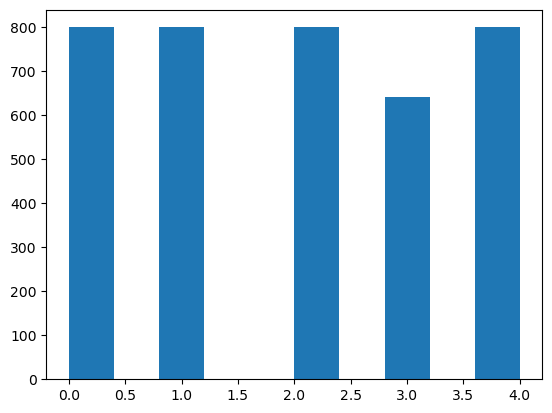

In [13]:
plt.hist(Y)

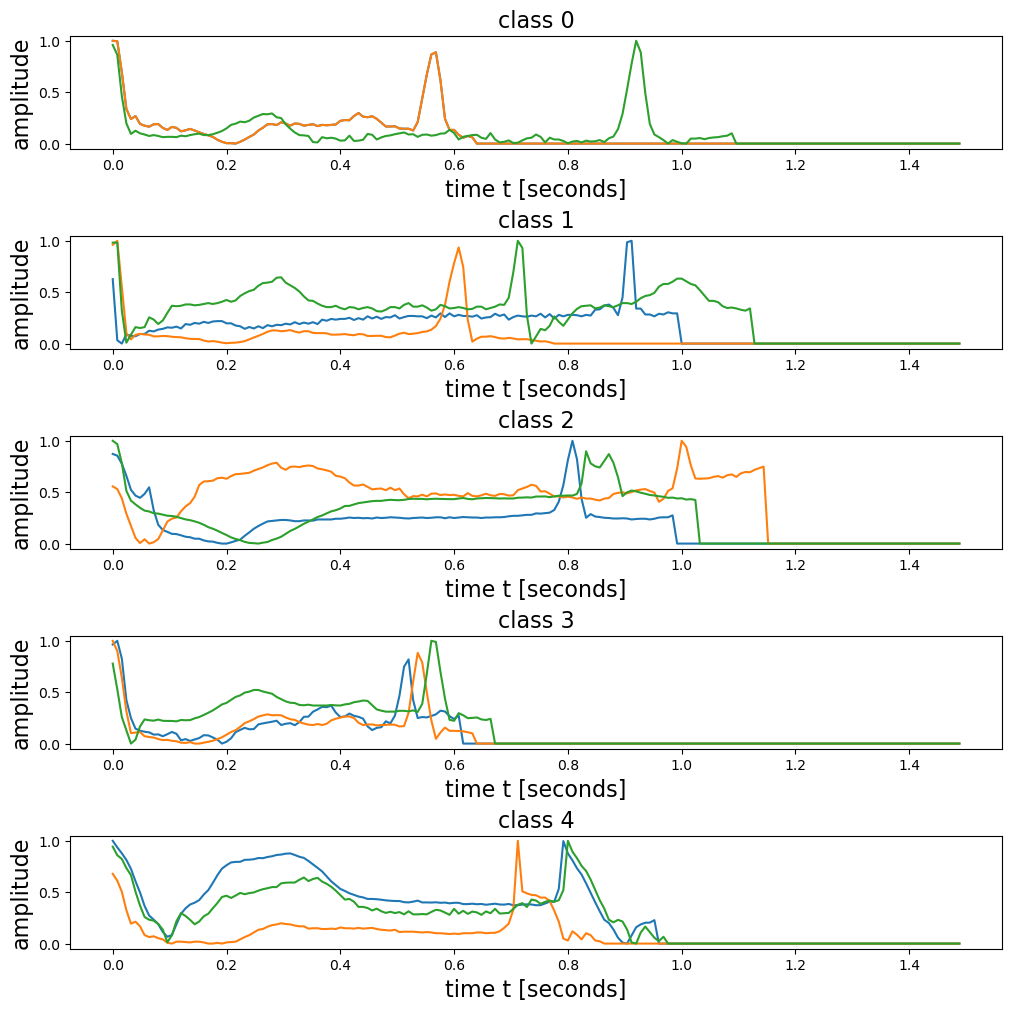

In [14]:
fs=125  # sampling frequency
Ts=1/fs # sampling interval
N=187 # the number of timepoints
Duration=N*Ts # duration of a signal
t=np.linspace(0, Duration-Ts, N) # array of timepoints
fig, ax = plt.subplots(5,1,constrained_layout=True, figsize=(10,10))
for c in range(0, 5):   
    for n in range(0, 3):
        idx=np.random.randint(0,10)
        ax[c].plot(t, X[Y==c][idx])        
        ax[c].set_xlabel('time t [seconds]', fontsize=16)
        ax[c].set_ylabel('amplitude', fontsize=16)
    ax[c].set_title('class '+str(c), fontsize=16)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)

In [16]:
dataset_train=MyDataset(X_train, Y_train)
dataset_val=MyDataset(X_val, Y_val)
dataset_test=MyDataset(X_test, Y_test)

In [17]:
loader_train = torch_dataloader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
loader_val = torch_dataloader(dataset_val, batch_size=128, shuffle=False, num_workers=0) 
loader_test = torch_dataloader(dataset_test, batch_size=128, shuffle=False, num_workers=0) 

## Create a model, and start the traning-validation-testing process

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=Net()
model.to(device)
x=dataset_train[0][0]
x=x.view(1,187).to(device) #change it to x=x.view(1,1,187).to(device) for CNN
z=model(x)

In [19]:
y_hat=nnF.softmax(z, dim=1)
y_hat

tensor([[0.1929, 0.1859, 0.2080, 0.2102, 0.2030]], grad_fn=<SoftmaxBackward0>)

use stochastic gradient descent as the optimization method

In [20]:
optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=1e-4)

In [21]:
loss_train_list=[]
acc_train_list=[]
acc_val_list=[]
epoch_save=-1

train/val/test over many epochs

In [22]:
for epoch in range(epoch_save+1, 100): #change 100 to a larger number if necessary
    #-------- training --------------------------------
    loss_train, acc_train =train(model, device, optimizer, loader_train, epoch)    
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)
    #-------- validation --------------------------------
    acc_val, other_val = test(model, device, loader_val)
    acc_val_list.append(acc_val)
    print('epoch', epoch, 'validation acc:', acc_val)
    #--------save model-------------------------
    result = (loss_train_list, acc_train_list, 
              acc_val_list, other_val)
    #change the name of the file if necessary
    save_checkpoint('H4P2T1_epoch'+str(epoch)+'.pt', model, optimizer, result, epoch)
    epoch_save=epoch

Train Epoch: 0 [0%]	Loss: 1.610989
epoch 0 training loss: 1.5487291379408403 acc: 0.3194645441389291
epoch 0 validation acc: 0.36688313
saved: H4P2T1_epoch0.pt
Train Epoch: 1 [0%]	Loss: 1.380822


/var/folders/xs/czdjg8q54cz21bqm4kfr5zz80000gn/T/ipykernel_2878/3076453557.py:13: RuntimeWarning: invalid value encountered in scalar divide
  prec[n]=TP/(TP+FP)


epoch 1 training loss: 1.2434270490299573 acc: 0.5289435600578871
epoch 1 validation acc: 0.512987
saved: H4P2T1_epoch1.pt
Train Epoch: 2 [0%]	Loss: 1.013151
epoch 2 training loss: 1.0298009975390001 acc: 0.6005788712011577
epoch 2 validation acc: 0.59090906
saved: H4P2T1_epoch2.pt
Train Epoch: 3 [0%]	Loss: 0.963923
epoch 3 training loss: 0.9397735406051982 acc: 0.625904486251809
epoch 3 validation acc: 0.6266234
saved: H4P2T1_epoch3.pt
Train Epoch: 4 [0%]	Loss: 0.994119
epoch 4 training loss: 0.8677623895081606 acc: 0.6743849493487699
epoch 4 validation acc: 0.66883117
saved: H4P2T1_epoch4.pt
Train Epoch: 5 [0%]	Loss: 0.863226
epoch 5 training loss: 0.8075132451274178 acc: 0.7007959479015919
epoch 5 validation acc: 0.6883117
saved: H4P2T1_epoch5.pt
Train Epoch: 6 [0%]	Loss: 0.818428
epoch 6 training loss: 0.7664796357805078 acc: 0.7196092619392185
epoch 6 validation acc: 0.6980519
saved: H4P2T1_epoch6.pt
Train Epoch: 7 [0%]	Loss: 0.669886
epoch 7 training loss: 0.7137589793313633 acc:

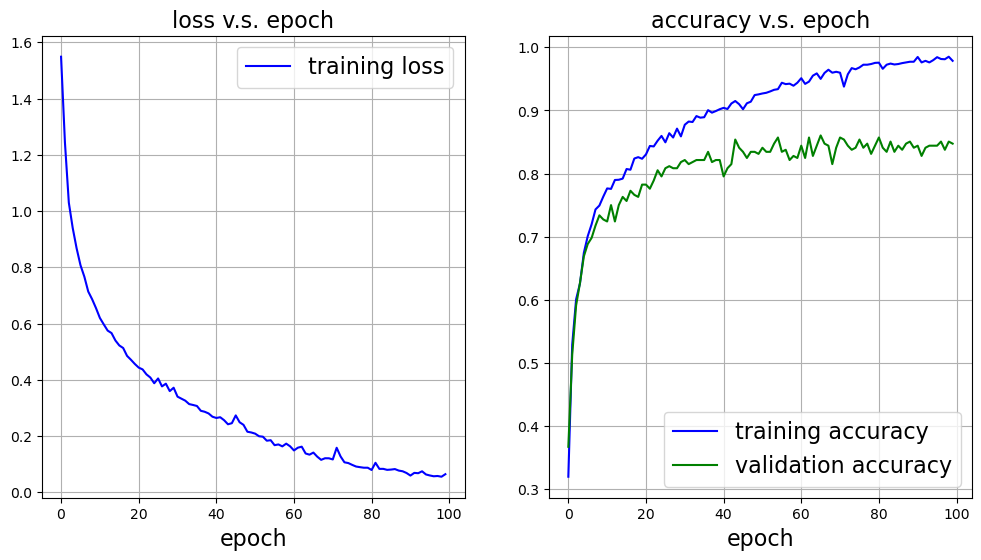

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].set_title('loss v.s. epoch',fontsize=16)
ax[0].plot(loss_train_list, '-b', label='training loss')
ax[0].set_xlabel('epoch',fontsize=16)
ax[0].legend(fontsize=16)
ax[0].grid(True)
ax[1].set_title('accuracy v.s. epoch',fontsize=16)
ax[1].plot(acc_train_list, '-b', label='training accuracy')
ax[1].plot(acc_val_list, '-g', label='validation accuracy')
ax[1].set_xlabel('epoch',fontsize=16)
ax[1].legend(fontsize=16)
ax[1].grid(True)

load the best model

In [24]:
best_epoch=np.argmax(acc_val_list)
best_epoch

65

In [25]:
checkpoint=torch.load('ECG_MLP_Pytorch_epoch'+str(best_epoch)+'.pt')
model=Net()
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device);
model.eval();

In [26]:
acc, (confusion, sens, prec) = test(model, device, loader_test)
print('Accuracy (average)', acc)
print('Sensitivity', sens)
print('Precision', prec)
print('Confusion \n', confusion)

Accuracy (average) 0.8530559
Sensitivity [0.67613637 0.87012988 0.94520545 0.86885244 0.92982459]
Precision [0.8321678  0.80239522 0.80701756 0.89830506 0.93529409]
Confusion 
 [[119.  29.  15.   6.   7.]
 [ 14. 134.   4.   1.   1.]
 [  1.   0. 138.   5.   2.]
 [  7.   0.   8. 106.   1.]
 [  2.   4.   6.   0. 159.]]
